<a href="https://colab.research.google.com/github/YusrilHasanuddin/Batik-classification-6-classes/blob/main/batikclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import zipfile
import cv2
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [ ]:
#First rearrange the data path so its similiar to these paths below
#dataset: https://drive.google.com/file/d/1uFnhO8WXdnyTBxGFy1qlqWU4iPmEF0kH/view

In [ ]:
train_dir = 'dataset_batik/Training'
val_dir = 'dataset_batik/Testing'

testing_sample_1 ='dataset_batik/Testing/Lereng'
testing_sample_2 = 'dataset_batik/Testing/Parang'
testing_sample_3 = 'dataset_batik/Testing/Ceplok'
testing_sample_4 = 'dataset_batik/Testing/Kawung'
testing_sample_5 = 'dataset_batik/Testing/Mix motif'
testing_sample_6 = 'dataset_batik/Testing/Nitik'

train_sample_1 ='dataset_batik/Training/Lereng'
train_sample_2 = 'dataset_batik/Training/Parang'
train_sample_3 = 'dataset_batik/Training/Ceplok'
train_sample_4 = 'dataset_batik/Training/Kawung'
train_sample_5 = 'dataset_batik/Training/Mix motif'
train_sample_6 = 'dataset_batik/Training/Nitik'

In [ ]:
for filename in os.listdir(testing_sample_1):
    if filename.endswith('.JPG') or filename.endswith('.jpg'):
        try:
            img = Image.open(testing_sample_1+"/"+filename)  # open the image file
            img.verify()  # verify that it is, in fact an image
            #print("Image save: {}".format(filename))
        except (IOError, SyntaxError) as e:
            print("Image error: {}".format(filename))
            os.remove(testing_sample_1+"/"+filename)

In [ ]:
print('total training sample_1 images:', len(os.listdir(train_sample_1)))
print('total training sample_2 images:', len(os.listdir(train_sample_2)))
print('total training sample_3 images:', len(os.listdir(train_sample_3)))
print('total training sample_4 images:', len(os.listdir(train_sample_4)))
print('total training sample_5 images:', len(os.listdir(train_sample_5)))
print('total training sample_6 images:', len(os.listdir(train_sample_6)))
print('total validation sample_1 images:', len(os.listdir(testing_sample_1)))
print('total validation sample_2 images:', len(os.listdir(testing_sample_2)))
print('total validation sample_3 images:', len(os.listdir(testing_sample_3)))
print('total validation sample_4 images:', len(os.listdir(testing_sample_4)))
print('total validation sample_5 images:', len(os.listdir(testing_sample_5)))
print('total validation sample_6 images:', len(os.listdir(testing_sample_6)))

total training sample_1 images: 52
total training sample_2 images: 165
total training sample_3 images: 132
total training sample_4 images: 89
total training sample_5 images: 32
total training sample_6 images: 110
total validation sample_1 images: 10
total validation sample_2 images: 10
total validation sample_3 images: 10
total validation sample_4 images: 10
total validation sample_5 images: 10
total validation sample_6 images: 10


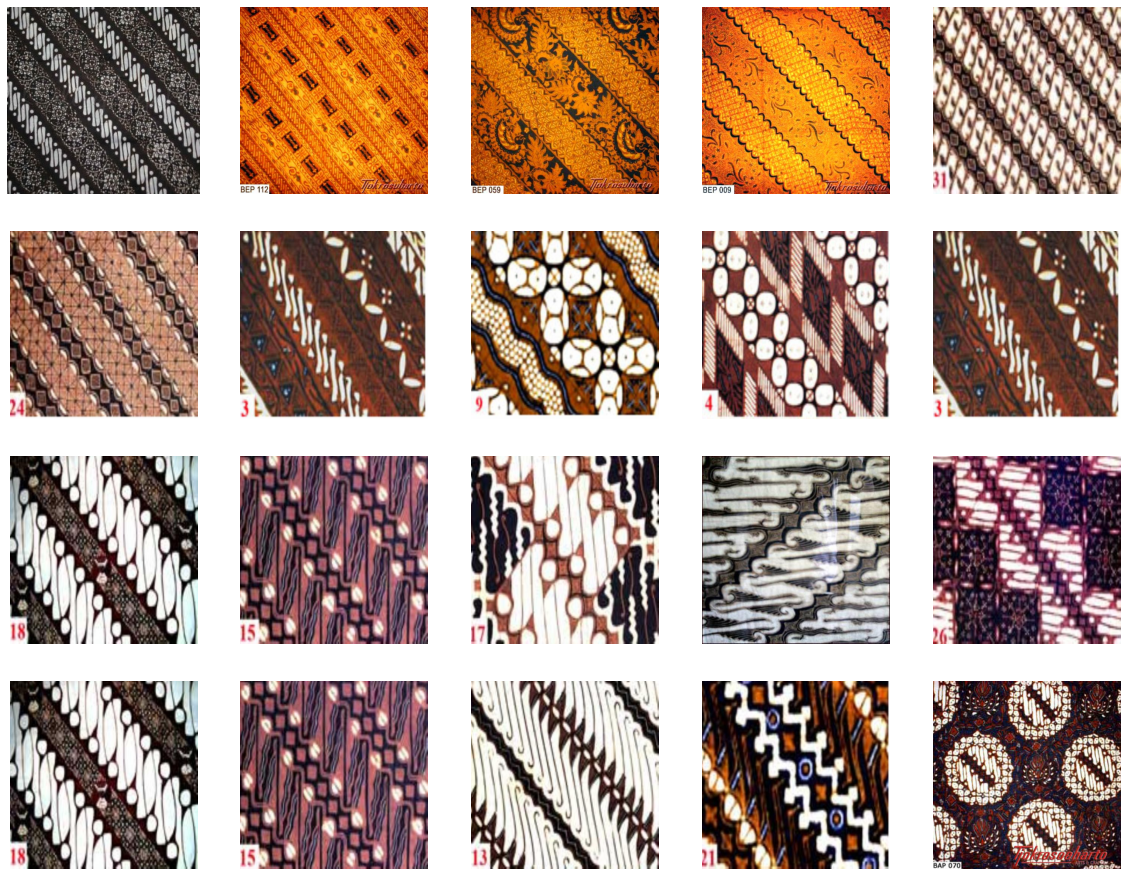

In [ ]:
%matplotlib inline


nrows = 5
ncols = 5

pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 10
next_sample_1_pix = [os.path.join(testing_sample_1, fname) 
                for fname in os.listdir(testing_sample_1)[pic_index-10:pic_index]]
next_sample_2_pix = [os.path.join(testing_sample_2, fname) 
                for fname in os.listdir(testing_sample_2)[pic_index-10:pic_index]]

for i, img_path in enumerate(next_sample_1_pix+next_sample_2_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
training_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
)
        
train_generator = training_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        class_mode='categorical',
        batch_size=10
)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        class_mode='categorical',
        batch_size=10
    )

Found 580 images belonging to 6 classes.
Found 60 images belonging to 6 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.93:
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight 
import numpy as np


class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_generator.classes),
                                        y = train_generator.classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))

train_class_weights = dict(enumerate(class_weights))

pre_trained_model = VGG16(input_shape=(150,150,3),
                        include_top=False)

last_output = pre_trained_model.output

x = layers.Flatten()(last_output)
x = layers.Dense(6, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

train_step_size = 585 // 10
val_step_size = 60 // 10

In [ ]:
history = model.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=train_step_size,
                        epochs=100,
                        validation_steps=val_step_size,
                        verbose=1,
                        class_weight=class_weights
                        )

Epoch 1/100
58/58 [==============================] - 7s 106ms/step - loss: 2.3245 - accuracy: 0.1517 - val_loss: 1.8102 - val_accuracy: 0.2333
Epoch 2/100
58/58 [==============================] - 5s 88ms/step - loss: 1.8079 - accuracy: 0.1586 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 3/100
58/58 [==============================] - 5s 88ms/step - loss: 1.7921 - accuracy: 0.0552 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 4/100
58/58 [==============================] - 5s 88ms/step - loss: 1.7922 - accuracy: 0.0552 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 5/100
58/58 [==============================] - 5s 88ms/step - loss: 1.7921 - accuracy: 0.0552 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 6/100
58/58 [==============================] - 5s 88ms/step - loss: 1.7921 - accuracy: 0.0552 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 7/100
58/58 [==============================] - 5s 88ms/step - loss: 1.7921 - accuracy: 0.0552 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch

In [ ]:
history1 = model.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=train_step_size,
                        epochs=100,
                        validation_steps=val_step_size,
                        verbose=1,
                        #class_weight=class_weights
                        )

Epoch 1/100
58/58 [==============================] - 6s 89ms/step - loss: 1.7864 - accuracy: 0.2534 - val_loss: 1.7922 - val_accuracy: 0.1667
Epoch 2/100
58/58 [==============================] - 5s 88ms/step - loss: 1.7726 - accuracy: 0.2845 - val_loss: 1.7936 - val_accuracy: 0.1667
Epoch 3/100
58/58 [==============================] - 5s 89ms/step - loss: 1.7605 - accuracy: 0.2845 - val_loss: 1.7956 - val_accuracy: 0.1667
Epoch 4/100
58/58 [==============================] - 5s 89ms/step - loss: 1.7503 - accuracy: 0.2845 - val_loss: 1.7982 - val_accuracy: 0.1667
Epoch 5/100
58/58 [==============================] - 5s 88ms/step - loss: 1.7413 - accuracy: 0.2845 - val_loss: 1.8009 - val_accuracy: 0.1667
Epoch 6/100
58/58 [==============================] - 5s 88ms/step - loss: 2.2787 - accuracy: 0.2569 - val_loss: 1.8038 - val_accuracy: 0.1667
Epoch 7/100
58/58 [==============================] - 5s 88ms/step - loss: 1.7289 - accuracy: 0.2845 - val_loss: 1.8073 - val_accuracy: 0.1667
Epoch 

## Method 2

In [ ]:
import glob
SIZE = 150

train_images = []
train_labels = [] 

for directory_path in glob.glob("dataset_batik/Training/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)


# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path in glob.glob("dataset_batik/Testing/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

Ceplok
dataset_batik/Training\Ceplok\0163-cl.jpg
dataset_batik/Training\Ceplok\0193-cl.jpg
dataset_batik/Training\Ceplok\0531-cl.jpg
dataset_batik/Training\Ceplok\batikceplok.jpg
dataset_batik/Training\Ceplok\batik_Grompol_motif_w.jpg
dataset_batik/Training\Ceplok\bbr-004-batik-yogya-kombinasi-rakitan-putri-solo.jpg
dataset_batik/Training\Ceplok\ceplok-bintang.jpg
dataset_batik/Training\Ceplok\ceplok-bligon.jpg
dataset_batik/Training\Ceplok\ceplok-bligon1.jpg
dataset_batik/Training\Ceplok\ceplok-ganggong.jpg
dataset_batik/Training\Ceplok\ceplok1.jpg
dataset_batik/Training\Ceplok\kotak-kawung-peksi-kreno.jpg
dataset_batik/Training\Ceplok\KP019.jpg
dataset_batik/Training\Ceplok\KP020.jpg
dataset_batik/Training\Ceplok\KP021.jpg
dataset_batik/Training\Ceplok\SC014.jpg
dataset_batik/Training\Ceplok\SC015.jpg
dataset_batik/Training\Ceplok\SC050.jpg
dataset_batik/Training\Ceplok\Solo-Cap-Parang-Ceplok Teblem.jpg
dataset_batik/Training\Ceplok\Truntum Mangkoro.jpg
dataset_batik/Training\Ceplok\

In [ ]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [ ]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [ ]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [ ]:
#define new cnn model

convkernel = (3, 3)  # convolution kernel
poolkernel = (2, 2)  # pooling kernel

modelCNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, convkernel, activation='relu', strides = 1, padding ='same', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(poolkernel, padding= 'same', strides = 2),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Conv2D(64, convkernel, activation='relu', strides = 1, padding='same'),
    tf.keras.layers.MaxPooling2D(poolkernel, padding= 'same', strides = 2),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Conv2D(32, convkernel, activation='relu', strides = 1, padding='same'),
    tf.keras.layers.MaxPooling2D(poolkernel, padding= 'same', strides = 2),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Conv2D(16, convkernel, activation='relu', strides = 1, padding='same'),
    tf.keras.layers.MaxPooling2D(poolkernel, padding= 'same', strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')]
)

modelCNN.summary()
feature_extractor = modelCNN.predict(x_train)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_SVM = features


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 150, 150, 128)     3584      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 75, 75, 128)      0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 75, 75, 128)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 64)        73792     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 38, 38, 64)       

In [ ]:
from sklearn import svm

clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X_for_SVM, y_train)

X_test_feature = modelCNN.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction_SVM = clf.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_SVM = le.inverse_transform(prediction_SVM)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVM))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, prediction_SVM)
cm

Accuracy =  0.16666666666666666


array([[ 0,  0,  0,  0,  0, 10],
       [ 0,  0,  0,  0,  0, 10],
       [ 0,  0,  0,  0,  0, 10],
       [ 0,  0,  0,  0,  0, 10],
       [ 0,  0,  0,  0,  0, 10],
       [ 0,  0,  0,  0,  0, 10]], dtype=int64)

In [ ]:
lin_clf = svm.LinearSVC()
lin_clf.fit(X_for_SVM, y_train)

#Now predict using the trained RF model. 
prediction_SVM2 = lin_clf.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_SVM2 = le.inverse_transform(prediction_SVM2)

#Confusion Matrix - verify accuracy of each class
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVM2))
cm2 = confusion_matrix(test_labels, prediction_SVM2)
cm2

Accuracy =  0.16666666666666666


array([[ 0,  0,  0,  0,  0, 10],
       [ 0,  0,  0,  0,  0, 10],
       [ 0,  0,  0,  0,  0, 10],
       [ 0,  0,  0,  0,  0, 10],
       [ 0,  0,  0,  0,  0, 10],
       [ 0,  0,  0,  0,  0, 10]], dtype=int64)

In [ ]:
test_labels_encoded

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

## Method 3

In [ ]:
#define new cnn model

convkernel = (3, 3)  # convolution kernel
poolkernel = (2, 2)  # pooling kernel

modelCNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, convkernel, activation='relu', strides = 1, padding ='same', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(poolkernel, padding= 'same', strides = 2),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Conv2D(64, convkernel, activation='relu', strides = 1, padding='same'),
    tf.keras.layers.MaxPooling2D(poolkernel, padding= 'same', strides = 2),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Conv2D(32, convkernel, activation='relu', strides = 1, padding='same'),
    tf.keras.layers.MaxPooling2D(poolkernel, padding= 'same', strides = 2),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Conv2D(16, convkernel, activation='relu', strides = 1, padding='same'),
    tf.keras.layers.MaxPooling2D(poolkernel, padding= 'same', strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')]
)

modelCNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 128)     3584      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 128)      0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 75, 75, 128)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 64)        73792     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 38, 38, 64)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 38, 38, 64)       

In [ ]:
modelCNN.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

train_step_size = 585 // 10
val_step_size = 60 // 10

history3 = modelCNN.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=train_step_size,
                        epochs=100,
                        validation_steps=val_step_size,
                        verbose=1,
                        class_weight=class_weights
                        )

Epoch 1/100
58/58 [==============================] - 6s 43ms/step - loss: 1.8070 - accuracy: 0.1379 - val_loss: 1.7921 - val_accuracy: 0.1667
Epoch 2/100
58/58 [==============================] - 4s 62ms/step - loss: 1.7943 - accuracy: 0.2121 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 3/100
58/58 [==============================] - 4s 63ms/step - loss: 1.7955 - accuracy: 0.1603 - val_loss: 1.7919 - val_accuracy: 0.1667
Epoch 4/100
58/58 [==============================] - 4s 63ms/step - loss: 1.7929 - accuracy: 0.1552 - val_loss: 1.7916 - val_accuracy: 0.1667
Epoch 5/100
58/58 [==============================] - 4s 63ms/step - loss: 1.7932 - accuracy: 0.1034 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 6/100
58/58 [==============================] - 4s 64ms/step - loss: 1.7925 - accuracy: 0.1448 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 7/100
58/58 [==============================] - 4s 64ms/step - loss: 1.7924 - accuracy: 0.1621 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 

KeyboardInterrupt: 

In [ ]:
history4 = modelCNN.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=train_step_size,
                        epochs=100,
                        validation_steps=val_step_size,
                        verbose=1,
                        #class_weight=class_weights
                        )

Epoch 1/100
58/58 [==============================] - 4s 63ms/step - loss: 1.7862 - accuracy: 0.2793 - val_loss: 1.7922 - val_accuracy: 0.1667
Epoch 2/100
58/58 [==============================] - 4s 64ms/step - loss: 1.7725 - accuracy: 0.2845 - val_loss: 1.7936 - val_accuracy: 0.1667
Epoch 3/100
58/58 [==============================] - 4s 63ms/step - loss: 1.7608 - accuracy: 0.2845 - val_loss: 1.7958 - val_accuracy: 0.1667
Epoch 4/100
58/58 [==============================] - 4s 63ms/step - loss: 1.7505 - accuracy: 0.2845 - val_loss: 1.7983 - val_accuracy: 0.1667
Epoch 5/100
58/58 [==============================] - 4s 63ms/step - loss: 1.7418 - accuracy: 0.2845 - val_loss: 1.8011 - val_accuracy: 0.1667
Epoch 6/100
34/58 [================>.............] - ETA: 1s - loss: 1.7362 - accuracy: 0.2824

KeyboardInterrupt: 